In [ ]:
from sklearn import preprocessing, pipeline, decomposition, cluster, metrics
from IPython.display import display
import numpy as np
import pandas as pd
import sqlite3 as sql
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import joblib as jb
from tqdm.auto import tqdm, trange
import os
import time

In [ ]:
# Clearing any existing outputs from the notebook

%rm -rf MiniBatchKMeans_encoders/
%rm -rf KMeans_encoders/    
%rm -rf BIRCH_encoders/ 
%rm -rf AC_encoders/
%rm -rf DBSCAN_encoders/ 

%rm -rf MiniBatchKMeans_estimators/
%rm -rf KMeans_estimators/
%rm -rf BIRCH_estimators/
%rm -rf AC_estimators/
%rm -rf DBSCAN_estimators/ 

%rm MiniBatchKMeans_cluster_centers.csv
%rm KMeans_cluster_centers.csv
%rm BIRCH_cluster_centers.csv
%rm AC_cluster_centers.csv
%rm DBSCAN_cluster_centers.csv

%rm MiniBatchKMeans_cluster_counts.csv
%rm KMeans_cluster_counts.csv
%rm BIRCH_cluster_counts.csv
%rm AC_cluster_counts.csv
%rm DBSCAN_cluster_counts.csv

%rm MiniBatchKMeans_collision_counts.csv
%rm KMeans_collision_counts.csv
%rm BIRCH_collision_counts.csv
%rm AC_collision_counts.csv
%rm DBSCAN_collision_counts.csv

rm: cannot remove 'MiniBatchKMeans_cluster_centers.csv': No such file or directory
rm: cannot remove 'KMeans_cluster_centers.csv': No such file or directory
rm: cannot remove 'BIRCH_cluster_centers.csv': No such file or directory
rm: cannot remove 'MiniBatchKMeans_cluster_counts.csv': No such file or directory
rm: cannot remove 'KMeans_cluster_counts.csv': No such file or directory
rm: cannot remove 'BIRCH_cluster_counts.csv': No such file or directory
rm: cannot remove 'MiniBatchKMeans_collision_counts.csv': No such file or directory
rm: cannot remove 'KMeans_collision_counts.csv': No such file or directory
rm: cannot remove 'BIRCH_collision_counts.csv': No such file or directory


# Introduction

As part of this project, we are trying to cluster the collision data and apply the vehicle make information to these clusters and prove the hypothesis that each motorcycles' make is part of collisions with approximately the same characteristics, and hence, the collisions of these vehicles with the same make are attributable to a single group.



# Data Input


We read the `collisions` and `parties` tables and dropped the unimportant features .
The data frames were, then preprocessed by filling missing values and encoding categorical features.
Eventually, a join is performed on the `collisions` and `parties` tables to create the final dataset, to be used by various clustering algorithms.

In [ ]:
# !wget https://www.dropbox.com/s/y5qu344p1hlp4o3/switrs.sqlite.zip
# !unzip switrs.sqlite.zip

In [ ]:
con = sql.connect("/content/switrs.sqlite")
cur = con.cursor()

In [ ]:
tables = [name[0] for name in cur.execute("SELECT name FROM sqlite_master")]

In [ ]:
print("Tables:")
print(tables)

Tables:
['case_ids', 'collisions', 'victims', 'parties']


In [ ]:
tables = ["collisions", "parties"]
print("Used tables: ")
print(tables)

Used tables: 
['collisions', 'parties']


In [ ]:
## Printing all features of both tables

cols = {table: list(map(lambda x: x[0], cur.execute("SELECT * FROM {}".format(table)).description)) for table in tables}
# print("Features of :")
for key,val in cols.items():
    print("Total features in "+ key +" table")
    display(val)
    print()

Total features in collisions table


['case_id',
 'jurisdiction',
 'officer_id',
 'reporting_district',
 'chp_shift',
 'population',
 'county_city_location',
 'county_location',
 'special_condition',
 'beat_type',
 'chp_beat_type',
 'city_division_lapd',
 'chp_beat_class',
 'beat_number',
 'primary_road',
 'secondary_road',
 'distance',
 'direction',
 'intersection',
 'weather_1',
 'weather_2',
 'state_highway_indicator',
 'caltrans_county',
 'caltrans_district',
 'state_route',
 'route_suffix',
 'postmile_prefix',
 'postmile',
 'location_type',
 'ramp_intersection',
 'side_of_highway',
 'tow_away',
 'collision_severity',
 'killed_victims',
 'injured_victims',
 'party_count',
 'primary_collision_factor',
 'pcf_violation_code',
 'pcf_violation_category',
 'pcf_violation',
 'pcf_violation_subsection',
 'hit_and_run',
 'type_of_collision',
 'motor_vehicle_involved_with',
 'pedestrian_action',
 'road_surface',
 'road_condition_1',
 'road_condition_2',
 'lighting',
 'control_device',
 'chp_road_type',
 'pedestrian_collision',



Total features in parties table


['id',
 'case_id',
 'party_number',
 'party_type',
 'at_fault',
 'party_sex',
 'party_age',
 'party_sobriety',
 'party_drug_physical',
 'direction_of_travel',
 'party_safety_equipment_1',
 'party_safety_equipment_2',
 'financial_responsibility',
 'hazardous_materials',
 'cellphone_in_use',
 'cellphone_use_type',
 'school_bus_related',
 'oaf_violation_code',
 'oaf_violation_category',
 'oaf_violation_section',
 'oaf_violation_suffix',
 'other_associate_factor_1',
 'other_associate_factor_2',
 'party_number_killed',
 'party_number_injured',
 'movement_preceding_collision',
 'vehicle_year',
 'vehicle_make',
 'statewide_vehicle_type',
 'chp_vehicle_type_towing',
 'chp_vehicle_type_towed',
 'party_race']

In [ ]:
#Excluding the trivial features
cols = {
    "collisions":
    [
        "case_id",
        #"jurisdiction",
        #"officer_id",
        #"reporting_district",
        #"chp_shift",
        #"population",
        "county_city_location",
        #"county_location",
        "special_condition",
        "beat_type",
        "chp_beat_type",
        "city_division_lapd",
        "chp_beat_class",
        "beat_number",
        "primary_road",
        "secondary_road",
        "distance",
        "direction",
        "intersection",
        "weather_1",
        "weather_2",
        "state_highway_indicator",
        "caltrans_county",
        "caltrans_district",
        "state_route",
        "route_suffix",
        "postmile_prefix",
        "postmile",
        "location_type",
        "ramp_intersection",
        "side_of_highway",
        "tow_away",
        "collision_severity",
        "killed_victims",
        "injured_victims",
        "party_count",
        "primary_collision_factor",
        "pcf_violation_code",
        "pcf_violation_category",
        "pcf_violation",
        "pcf_violation_subsection",
        "hit_and_run",
        "type_of_collision",
        "motor_vehicle_involved_with",
        "pedestrian_action",
        "road_surface",
        "road_condition_1",
        "road_condition_2",
        "lighting",
        "control_device",
        "chp_road_type",
        "pedestrian_collision",
        "bicycle_collision",
        "motorcycle_collision",
        "truck_collision",
        "not_private_property",
        "alcohol_involved",
        "statewide_vehicle_type_at_fault",
        "chp_vehicle_type_at_fault",
        "severe_injury_count",
        "other_visible_injury_count",
        "complaint_of_pain_injury_count",
        "pedestrian_killed_count",
        "pedestrian_injured_count",
        "bicyclist_killed_count",
        "bicyclist_injured_count",
        "motorcyclist_killed_count",
        "motorcyclist_injured_count",
        "primary_ramp",
        "secondary_ramp",
        "latitude",
        "longitude",
        "collision_date",
        "collision_time",
        #"process_date"
    ],
    
    "parties":
    [
        #"id",
        "case_id",
        "party_number",
        "party_type",
        "at_fault",
        "party_sex",
        "party_age",
        "party_sobriety",
        "party_drug_physical",
        "direction_of_travel",
        "party_safety_equipment_1",
        "party_safety_equipment_2",
        "financial_responsibility",
        "hazardous_materials",
        #"cellphone_in_use",
        #"cellphone_use_type",
        "school_bus_related",
        "oaf_violation_code",
        "oaf_violation_category",
        "oaf_violation_section",
        "oaf_violation_suffix",
        "other_associate_factor_1",
        "other_associate_factor_2",
        "party_number_killed",
        "party_number_injured",
        "movement_preceding_collision",
        "vehicle_year",
        "vehicle_make",
        #"statewide_vehicle_type",
        #"chp_vehicle_type_towing",
        #"chp_vehicle_type_towed",
        "party_race"
    ]
}

for key,val in cols.items():
    print("Relevant features in " + key + " table")
    display(val)
    print()

Relevant features in collisions table


['case_id',
 'county_city_location',
 'special_condition',
 'beat_type',
 'chp_beat_type',
 'city_division_lapd',
 'chp_beat_class',
 'beat_number',
 'primary_road',
 'secondary_road',
 'distance',
 'direction',
 'intersection',
 'weather_1',
 'weather_2',
 'state_highway_indicator',
 'caltrans_county',
 'caltrans_district',
 'state_route',
 'route_suffix',
 'postmile_prefix',
 'postmile',
 'location_type',
 'ramp_intersection',
 'side_of_highway',
 'tow_away',
 'collision_severity',
 'killed_victims',
 'injured_victims',
 'party_count',
 'primary_collision_factor',
 'pcf_violation_code',
 'pcf_violation_category',
 'pcf_violation',
 'pcf_violation_subsection',
 'hit_and_run',
 'type_of_collision',
 'motor_vehicle_involved_with',
 'pedestrian_action',
 'road_surface',
 'road_condition_1',
 'road_condition_2',
 'lighting',
 'control_device',
 'chp_road_type',
 'pedestrian_collision',
 'bicycle_collision',
 'motorcycle_collision',
 'truck_collision',
 'not_private_property',
 'alcohol_in


Relevant features in parties table


['case_id',
 'party_number',
 'party_type',
 'at_fault',
 'party_sex',
 'party_age',
 'party_sobriety',
 'party_drug_physical',
 'direction_of_travel',
 'party_safety_equipment_1',
 'party_safety_equipment_2',
 'financial_responsibility',
 'hazardous_materials',
 'school_bus_related',
 'oaf_violation_code',
 'oaf_violation_category',
 'oaf_violation_section',
 'oaf_violation_suffix',
 'other_associate_factor_1',
 'other_associate_factor_2',
 'party_number_killed',
 'party_number_injured',
 'movement_preceding_collision',
 'vehicle_year',
 'vehicle_make',
 'party_race']

The `collisions` table is read with a `SELECT` query with non-trivial columns filtered.

In [ ]:
def convert_list(L):
    A = ""
    for x in L:
        A += x + ", "
    A = A[:-2]
    return A

df = {}

#Selecting records in collisions where a motorcycle was involved
motorcycle_collisions = "SELECT " + convert_list(cols["collisions"]) + " FROM collisions WHERE motorcycle_collision=1"
df["collisions"] = pd.DataFrame([list(x) for x in cur.execute(motorcycle_collisions)], columns=cols["collisions"])

print("Records in collisions table: {}".format(df["collisions"].shape[0]))
print("Features in collisions table: {}".format(df["collisions"].shape[1]))
display(df["collisions"].head())

Records in collisions table: 278684
Features in collisions table: 68


,case_id,county_city_location,special_condition,beat_type,chp_beat_type,city_division_lapd,chp_beat_class,beat_number,primary_road,secondary_road,distance,direction,intersection,weather_1,weather_2,state_highway_indicator,caltrans_county,caltrans_district,state_route,route_suffix,postmile_prefix,postmile,location_type,ramp_intersection,side_of_highway,tow_away,collision_severity,killed_victims,injured_victims,party_count,primary_collision_factor,pcf_violation_code,pcf_violation_category,pcf_violation,pcf_violation_subsection,hit_and_run,type_of_collision,motor_vehicle_involved_with,pedestrian_action,road_surface,road_condition_1,road_condition_2,lighting,control_device,chp_road_type,pedestrian_collision,bicycle_collision,motorcycle_collision,truck_collision,not_private_property,alcohol_involved,statewide_vehicle_type_at_fault,chp_vehicle_type_at_fault,severe_injury_count,other_visible_injury_count,complaint_of_pain_injury_count,pedestrian_killed_count,pedestrian_injured_count,bicyclist_killed_count,bicyclist_injured_count,motorcyclist_killed_count,motorcyclist_injured_count,primary_ramp,secondary_ramp,latitude,longitude,collision_date,collision_time
0,3982906,1972,0,not chp,not chp,None,not chp,None,SEPULVEDA,HICKORY,0.0,None,1.0,clear,None,0.0,None,NaN,NaN,None,None,NaN,None,None,None,1.0,severe injury,0.0,1.0,2,vehicle code violation,None,automobile right of way,21801.0,A,not hit and run,broadside,other motor vehicle,no pedestrian involved,dry,normal,None,daylight,functioning,0,0,0,1,0,1,1.0,passenger car,None,1,0,0,0,0,0,0,0,1,None,None,NaN,NaN,2009-01-12,17:10:00
1,3984246,3607,0,chp state highway,interstate,None,chp other,103,RT 10,4TH ST,51.0,south,0.0,clear,None,1.0,san bernardino,8.0,10.0,None,None,5.391,ramp,"ramp exit, last 50 feet",westbound,1.0,fatal,1.0,0.0,2,vehicle code violation,None,speeding,22350.0,None,not hit and run,hit object,fixed object,no pedestrian involved,dry,normal,None,daylight,functioning,1,0,0,1,0,1,NaN,motorcycle or scooter,motorcycle,0,0,0,0,0,0,0,1,0,TO,None,NaN,NaN,2009-01-11,13:02:00
2,3984329,2000,0,chp county roadline,county road line,None,chp other,044,COUNTY ROAD 145,RT 41,7392.0,east,0.0,cloudy,None,0.0,None,NaN,NaN,None,None,NaN,None,None,None,1.0,fatal,1.0,1.0,2,vehicle code violation,None,wrong side of road,21460.0,A,not hit and run,head-on,other motor vehicle,no pedestrian involved,dry,normal,None,daylight,none,0,0,0,1,0,1,NaN,motorcycle or scooter,motorcycle,0,0,1,0,0,0,0,1,0,None,None,37.01290,-119.76988,2009-01-01,13:45:00
3,3984352,1942,0,not chp,not chp,None,not chp,6T7,HARVARD BL,3RD ST,0.0,None,1.0,clear,None,0.0,None,NaN,NaN,None,None,NaN,None,None,None,1.0,fatal,1.0,0.0,2,vehicle code violation,None,automobile right of way,21802.0,A,not hit and run,broadside,other motor vehicle,no pedestrian involved,dry,normal,None,daylight,functioning,0,0,0,1,0,1,NaN,passenger car,"passenger car, station",0,0,0,0,0,0,0,1,0,None,None,NaN,NaN,2009-01-11,14:50:00
4,3984398,3400,0,chp county roadline,county road line,None,chp other,073,GERBER RD,COUNTRY PARK DR,85.0,west,0.0,clear,None,0.0,None,NaN,NaN,None,None,NaN,None,None,None,1.0,fatal,1.0,0.0,2,vehicle code violation,None,speeding,22350.0,None,not hit and run,broadside,other motor vehicle,no pedestrian involved,dry,normal,None,dusk or dawn,functioning,0,0,0,1,0,1,NaN,motorcycle or scooter,motorcycle,0,0,0,0,0,0,0,1,0,None,None,38.48171,-121.40174,2009-01-29,07:45:00


# Data preprocessing

The timestamp details , `collision_date` and `collision_time` are processed generating one column per field (i.e. year, month, day, hour, minute, second) to make the computations easier for preprocessing missing values.

In [ ]:
df["collisions"].loc[:, ["collision_date", "collision_time"]].isnull().sum()

collision_date      0
collision_time    770
dtype: int64

`collision_time` has some missing values.
Median value of timestamps distribution within the 24-hours day is used to fill missing values.

In [ ]:
def get_seconds(hour, minute, second):
    return hour*3600 + minute*60 + second

def get_hms(seconds):
    hour = seconds // 3600
    seconds -= hour * 3600
    minute = seconds // 60
    seconds -= minute * 60
    second = round(seconds)
    return int(hour), int(minute), int(second)

def get_date_cols(col_date, col_time=None):
    
    year = col_date.apply(lambda x: pd.Timestamp(x).year)
    month = col_date.apply(lambda x: pd.Timestamp(x).month)
    day = col_date.apply(lambda x: pd.Timestamp(x).day)
    
    df = pd.DataFrame({"year": year.values, "month": month.values, "day": day.values}, index=col_date.index)
    
    if type(col_time) == pd.Series:
        
        # fill missing times with median
        time_median = col_time.apply(lambda x: get_seconds(*np.array(x.split(":")).astype(int)) if type(x)==str else np.nan).dropna().median()
        col_time = col_time.fillna(value="{:02d}:{:02d}:{:02d}".format(*get_hms(time_median)))

        hour = col_time.apply(lambda x: x.split(":")[0]).astype(int)
        minute = col_time.apply(lambda x: x.split(":")[1]).astype(int)
        second = col_time.apply(lambda x: x.split(":")[2]).astype(int)
        
        # pack time fields with date's
        df = df.join(pd.DataFrame({"hour": hour, "minute": minute, "second": second}, index=col_time.index))
    
    return df

df["collisions"] = df["collisions"].join(get_date_cols(df["collisions"].collision_date, df["collisions"].collision_time).rename(columns={var: "collision_date_"+var for var in ["year", "month", "day", "hour", "minute", "second"]}))
df["collisions"] = df["collisions"].drop(columns=["collision_date", "collision_time"])

df["collisions"].loc[:, ["collision_date_" + var for var in ["year", "month", "day", "hour", "minute", "second"]]].describe()

,collision_date_year,collision_date_month,collision_date_day,collision_date_hour,collision_date_minute,collision_date_second
count,278684.000000,278684.000000,278684.000000,278684.000000,278684.000000,278684.0
mean,2011.435009,6.657792,15.692106,13.841179,27.676067,0.0
std,5.716283,3.165702,8.775089,4.964365,17.467590,0.0
min,2001.000000,1.000000,1.000000,0.000000,0.000000,0.0
25%,2007.000000,4.000000,8.000000,11.000000,13.000000,0.0
50%,2012.000000,7.000000,16.000000,15.000000,30.000000,0.0
75%,2016.000000,9.000000,23.000000,17.000000,43.000000,0.0
max,2021.000000,12.000000,31.000000,23.000000,59.000000,0.0


Now missing values are filled using `"None"` label for categorical and $0$ for numeric features.
Maybe $0$ is not the best value to use but it does not belongs to other significant values of numeric columns.

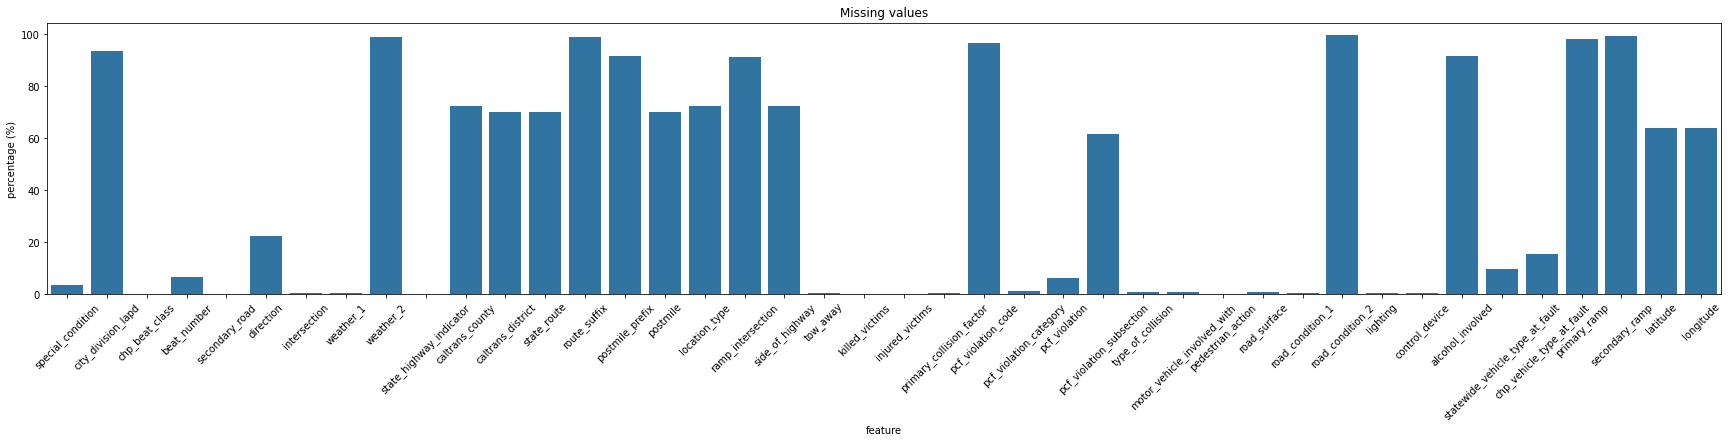

,intersection,state_highway_indicator,caltrans_district,state_route,postmile,tow_away,killed_victims,injured_victims,pcf_violation,alcohol_involved,latitude,longitude
count,276863.000000,278603.000000,83831.000000,83831.000000,83831.000000,277062.000000,278633.000000,278629.000000,260898.000000,23197.0,100605.000000,100605.000000
mean,0.212206,0.412605,6.421873,125.206368,18.627243,0.599721,0.033094,0.906061,22049.515581,1.0,35.468482,-119.306148
std,0.408871,0.492304,3.365053,187.451468,18.816228,0.489956,0.184336,0.581412,1482.981066,0.0,2.124129,1.990000
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,32.500600,-124.450260
25%,0.000000,0.000000,4.000000,10.000000,4.960000,0.000000,0.000000,1.000000,21801.000000,1.0,33.887930,-121.364490
50%,0.000000,0.000000,7.000000,75.000000,13.950000,1.000000,0.000000,1.000000,22107.000000,1.0,34.232680,-118.414500
75%,0.000000,1.000000,8.000000,110.000000,26.250000,1.000000,0.000000,1.000000,22350.000000,1.0,37.598920,-117.732540
max,1.000000,1.000000,12.000000,980.000000,406.580000,1.000000,5.000000,27.000000,38506.000000,1.0,42.001660,-114.107620


In [ ]:
def preprocess_missing(df, figsize=(30,5), none_is_na = True):
    
    ''' Fill missing values: with "None" for labels, with 0 for numeric features '''
    
    df = df.copy()
    
    if none_is_na:
        df = df.replace("None", np.nan)
    
    null_counts = (df.isnull().sum() / df.shape[0] * 100).loc[lambda x: x!=0]
    
    fig,ax = plt.subplots(figsize=figsize)
    ax = sns.barplot(x=null_counts.index, y=null_counts.values, color="C0", ax=ax)
    ax.tick_params(axis="x", rotation=45)
    ax.set_title("Missing values")
    ax.set_xlabel("feature")
    ax.set_ylabel("percentage (%)")
    plt.show()
    
    drop_cols = null_counts.loc[lambda x: x==100].index.tolist()
    df = df.drop(columns=drop_cols)
    if len(drop_cols) != 0:
        print("Completely null features:")
        for col in drop_cols:
            print("\t"+col)
    
    null_obj = df.dtypes.loc[null_counts.index].loc[lambda x: x==object]
    null_numeric = df.dtypes.loc[null_counts.index].loc[lambda x: x!=object]
    
    df.loc[:,null_obj.index] = df.loc[:,null_obj.index].fillna(value="None")
    
    display(df.loc[:,null_numeric.index].describe())
    
    # all numeric features with missing values can be filled with 0 in all tables, because of this the following line of code is commented
    #fill_numeric = input("Fill missing numeric values with 0? (Y/n): ")
    fill_numeric = "y"
    
    if fill_numeric in ["Y", "y", ""]:
        df.loc[:, null_numeric.index] = df.loc[:, null_numeric.index].fillna(value=0)
        
    return df

df["collisions"] = preprocess_missing(df["collisions"])

In [ ]:
# get collisions' parties on a motorcycle (or scooter)
motorcycle_collisions = "SELECT " + convert_list(cols["parties"]) + " FROM parties "
motorcycle_collisions += "WHERE case_id IN (" + convert_list(df["collisions"].case_id) + ") AND statewide_vehicle_type = 'motorcycle or scooter'"
df["parties"] = pd.DataFrame([list(x) for x in cur.execute(motorcycle_collisions)], columns=cols["parties"])

display(df["parties"].head())
print("\nEntries: {}".format(df["parties"].shape[0]))
print("Features: {}".format(df["parties"].shape[1]))

,case_id,party_number,party_type,at_fault,party_sex,party_age,party_sobriety,party_drug_physical,direction_of_travel,party_safety_equipment_1,party_safety_equipment_2,financial_responsibility,hazardous_materials,school_bus_related,oaf_violation_code,oaf_violation_category,oaf_violation_section,oaf_violation_suffix,other_associate_factor_1,other_associate_factor_2,party_number_killed,party_number_injured,movement_preceding_collision,vehicle_year,vehicle_make,party_race
0,3982906,2,driver,0,male,25.0,impairment unknown,G,west,"driver, motorcycle helmet used",None,proof of insurance obtained,NaN,NaN,None,None,None,None,None,None,0,1,proceeding straight,2008.0,kawasaki,white
1,3984246,1,driver,1,male,28.0,None,under drug influence,east,not required,"driver, motorcycle helmet used",no proof of insurance obtained,NaN,NaN,None,None,None,None,none apparent,None,1,0,proceeding straight,2005.0,suzuki,other
2,3984329,1,driver,1,female,38.0,had not been drinking,under drug influence,east,not required,"driver, motorcycle helmet used",proof of insurance obtained,NaN,NaN,None,wrong side of road,21650,None,violation,None,1,0,crossed into opposing lane,2006.0,suzuki,white
3,3984352,2,driver,0,male,21.0,had not been drinking,under drug influence,west,air bag deployed,"driver, motorcycle helmet used",None,NaN,NaN,None,None,None,None,none apparent,None,1,0,proceeding straight,2007.0,ducati,white
4,3984398,1,driver,1,male,20.0,had not been drinking,None,west,not required,"driver, motorcycle helmet used",None,NaN,NaN,None,None,None,None,none apparent,None,1,0,proceeding straight,2003.0,honda,black



Entries: 260795
Features: 26


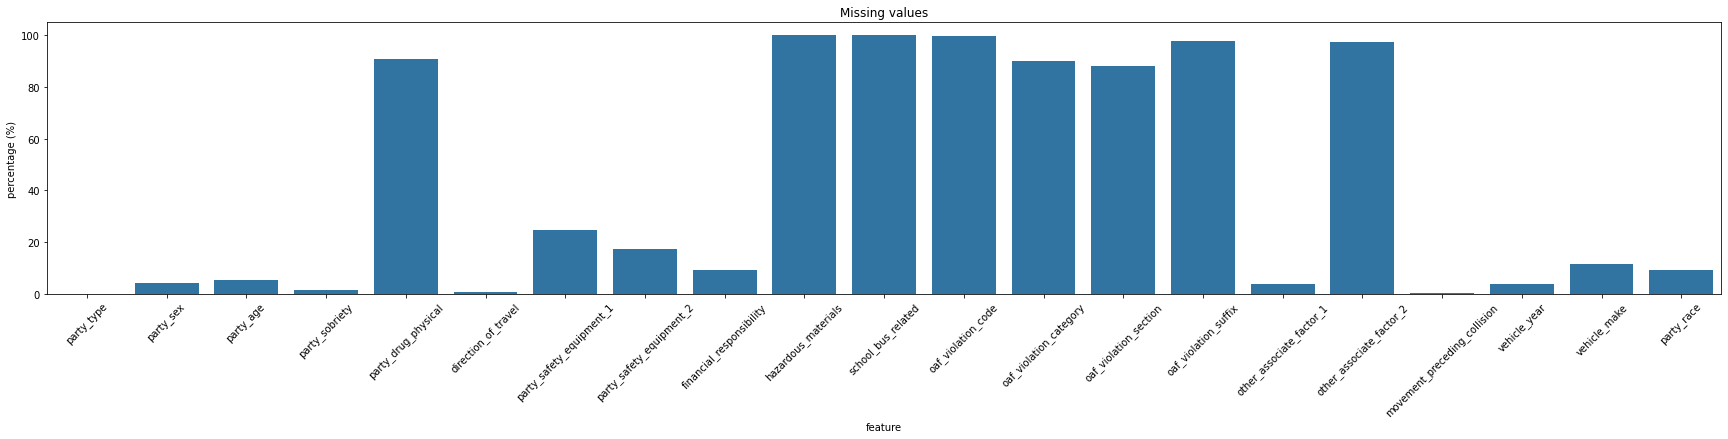

,party_age,hazardous_materials,school_bus_related,vehicle_year
count,246234.000000,223.0,288.0,250193.000000
mean,37.338905,1.0,1.0,2004.461556
std,14.208053,0.0,0.0,8.850637
min,0.000000,1.0,1.0,1016.000000
25%,25.000000,1.0,1.0,2001.000000
50%,34.000000,1.0,1.0,2005.000000
75%,48.000000,1.0,1.0,2009.000000
max,104.000000,1.0,1.0,2075.000000


In [ ]:
df["parties"] = preprocess_missing(df["parties"])

In [ ]:
print("Motorcycles without make: {}".format((df["parties"].vehicle_make == "None").sum()))

Motorcycles without make: 29830


Motorcycles without a make are not useful so they are removed.

In [ ]:
df["parties"] = df["parties"].loc[df["parties"].vehicle_make != "None"]

Collisions data are merged into `parties` table using case ids.
Moreover, in this way collisions without any party entry will be excluded.

In [ ]:
df = df["parties"].merge(df["collisions"], on="case_id", how="left").set_index(["case_id", "party_number"]).sort_index()
print("Dataset shape: {}".format(df.shape))

Dataset shape: (230965, 95)


Now categorical features are encoded.

In [ ]:
def encode_labels(df, progress=True):
    df = df.copy()
    label_encoders = {}
    for col in tqdm(df.dtypes.loc[lambda x: x==object].index, disable=not progress):
        label_encoders[col] = preprocessing.LabelEncoder().fit(df.loc[:,col])
        df.loc[:,col] = label_encoders[col].transform(df.loc[:,col])
    return df, label_encoders

df_enc, label_encoders = encode_labels(df)

  0%|          | 0/54 [00:00<?, ?it/s]

The vehicle make information has been dropped to cluster the collisions independent of the target variable.

In [ ]:
targets = ["vehicle_make"]
x,y = df_enc.drop(columns=targets), df_enc.loc[:,targets]

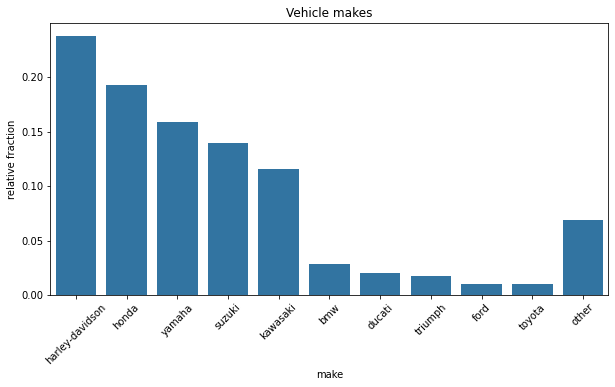

In [ ]:
N = 10 # how many makes to show separately
vehicle_make_frac = (df.vehicle_make.value_counts() / df.shape[0]).sort_values(ascending=False).iloc[:N]
vehicle_make_frac = vehicle_make_frac.append(pd.Series([1 - vehicle_make_frac.sum()], index=["other"]))

fig,ax = plt.subplots(figsize=(10,5))
ax.set_title("Vehicle makes")
ax.set_ylabel("relative fraction")
ax.set_xlabel("make")
ax.tick_params(axis="x", rotation=45)
ax = sns.barplot(x=vehicle_make_frac.index, y=vehicle_make_frac.values, color="C0", ax=ax)

del vehicle_make_frac


# Principal Component Analysis

PCA could be used to reduce the dimensionality of the data.
This is possible only if a restricted number of the first principal components contain a sufficient amount of the original variance.

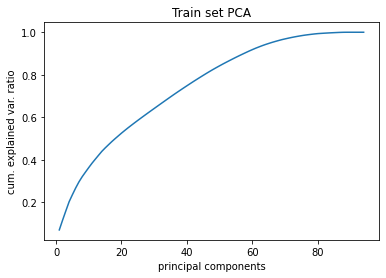

In [ ]:
def get_pca_pipe(x):
    ''' Fit PCA and return model '''
    pca_pipe = pipeline.Pipeline([
        ("scaler", preprocessing.StandardScaler()),
        ("pca", decomposition.PCA(random_state=1))
    ])
    pca_pipe = pca_pipe.fit(x)
    return pca_pipe

pca_pipe = get_pca_pipe(x)
pca = pca_pipe.named_steps["pca"]

ax = sns.lineplot(x=np.arange(1,pca.n_components_+1), y=pca.explained_variance_ratio_.cumsum())
ax.set_title("Train set PCA")
ax.set_xlabel("principal components")
_ = ax.set_ylabel("cum. explained var. ratio")

First principal components do not contain much of the original variance to be representative of the starting space, so PCA results are not used.


# Singular Value Decomposition (SVD)

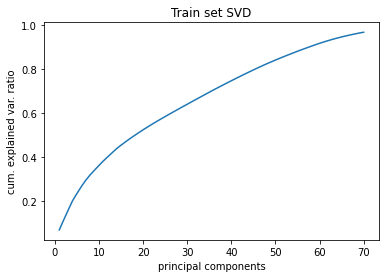

In [ ]:
def get_svd_pipe(x):
    ''' Fit SVD and return model '''
    svd_pipe = pipeline.Pipeline([
        ("scaler", preprocessing.StandardScaler()),
        ("svd", decomposition.TruncatedSVD(n_components=70))
    ])
    svd_pipe = svd_pipe.fit(x)
    return svd_pipe

svd_pipe = get_svd_pipe(x)
svd = svd_pipe.named_steps["svd"]

ax = sns.lineplot(x=np.arange(1,svd.components_.shape[0]+1), y=svd.explained_variance_ratio_.cumsum())
ax.set_title("Train set SVD")
ax.set_xlabel("principal components")
_ = ax.set_ylabel("cum. explained var. ratio")

# Clustering Algorithms

Clustering Algorithms Used: 


*   Mini Batch K-means
*   K-means
*   BIRCH
*   Agglomerative
*   DBSCAN


### Mini Batch K-means

In [ ]:
MiniBatchKmeans_train = x.copy()
MiniBatchKMeans_target = y.copy()
MiniBatchKMeans_df= df.copy()
MiniBatchKMeans_df_enc = df_enc.copy()

Before introducing clusters in data, their inertia is studied varying the groups number used by estimator.
Then clusters are produced using a value near the elbow of the resulting inertia plot.


In [ ]:
def get_MiniBatchKMeans_pipe(x, n, batch_size=1000):
    cluster_pipe = pipeline.Pipeline([
        ("scaler", preprocessing.StandardScaler()),
        ("cluster", cluster.MiniBatchKMeans(n_clusters=n, batch_size=batch_size, random_state=1))
    ])
    cluster_pipe = cluster_pipe.fit(x)
    return cluster_pipe

  0%|          | 0/149 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


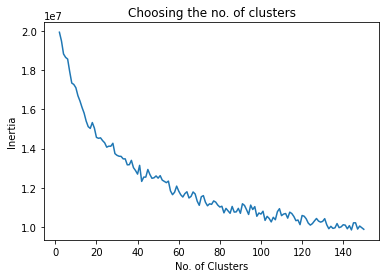

In [ ]:
N = 150 # maximum clusters tested
inertia = [cluster_pipe.named_steps["cluster"].inertia_ for cluster_pipe in jb.Parallel(n_jobs=-1)(jb.delayed(get_MiniBatchKMeans_pipe)(MiniBatchKmeans_train, n) for n in trange(2,N+1))]

ax = sns.lineplot(x=np.arange(2,N+1), y=inertia)
ax.set_title("Choosing the no. of clusters")
ax.set_xlabel("No. of Clusters")
_ = ax.set_ylabel("Inertia")

From the above graph, we can select the inflection point as $60$ for deciding the number of clusters.

In [ ]:
# MiniBatchKmeans_train.drop('cluster', axis=1, inplace=True)
# MiniBatchKMeans_df.drop('cluster', axis=1, inplace=True)
# MiniBatchKMeans_df_enc.drop('cluster', axis=1, inplace=True)

In [ ]:
start = time.time()
cluster_pipe = get_MiniBatchKMeans_pipe(MiniBatchKmeans_train, n=60)
stop = time.time()
print(f"Training time for Mini Batch K-means Model: {stop - start}s")
cluster_values = cluster_pipe.predict(MiniBatchKmeans_train)

Training time for Mini Batch K-means Model: 0.8838932514190674s


In [ ]:
MiniBatchKmeans_train.insert(loc=MiniBatchKmeans_train.shape[1], column="cluster", value=cluster_values)
MiniBatchKMeans_df.insert(loc=MiniBatchKMeans_df.shape[1], column="cluster", value=cluster_values)
MiniBatchKMeans_df_enc.insert(loc=MiniBatchKMeans_df_enc.shape[1], column="cluster", value=cluster_values)

Clusters' properties can be retrieved form their centers.

In [ ]:
def decode_labels(df, encoders, progress=False):
    df = df.copy()
    for col in encoders.keys():
        if col in df.columns:
            df.loc[:,col] = encoders[col].inverse_transform(df.loc[:,col].apply(lambda x: round(x))) # decode with the nearest valid label
    return df

# cluster characteristics
cluster_centers = pd.DataFrame(cluster_pipe.named_steps["scaler"].inverse_transform(cluster_pipe.named_steps["cluster"].cluster_centers_), columns=MiniBatchKmeans_train.drop(columns="cluster").columns)
cluster_centers.index.name = "cluster"
cluster_centers = decode_labels(cluster_centers, label_encoders)
cluster_centers.head()

,party_type,at_fault,party_sex,party_age,party_sobriety,party_drug_physical,direction_of_travel,party_safety_equipment_1,party_safety_equipment_2,financial_responsibility,hazardous_materials,school_bus_related,oaf_violation_code,oaf_violation_category,oaf_violation_section,oaf_violation_suffix,other_associate_factor_1,other_associate_factor_2,party_number_killed,party_number_injured,movement_preceding_collision,vehicle_year,party_race,county_city_location,special_condition,beat_type,chp_beat_type,city_division_lapd,chp_beat_class,beat_number,primary_road,secondary_road,distance,direction,intersection,weather_1,weather_2,state_highway_indicator,caltrans_county,caltrans_district,...,pcf_violation_category,pcf_violation,pcf_violation_subsection,hit_and_run,type_of_collision,motor_vehicle_involved_with,pedestrian_action,road_surface,road_condition_1,road_condition_2,lighting,control_device,chp_road_type,pedestrian_collision,bicycle_collision,motorcycle_collision,truck_collision,not_private_property,alcohol_involved,statewide_vehicle_type_at_fault,chp_vehicle_type_at_fault,severe_injury_count,other_visible_injury_count,complaint_of_pain_injury_count,pedestrian_killed_count,pedestrian_injured_count,bicyclist_killed_count,bicyclist_injured_count,motorcyclist_killed_count,motorcyclist_injured_count,primary_ramp,secondary_ramp,latitude,longitude,collision_date_year,collision_date_month,collision_date_day,collision_date_hour,collision_date_minute,collision_date_second
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,driver,0.169540,male,36.760057,had not been drinking,None,north,lap/shoulder harness used,"driver, motorcycle helmet not used",officer called away before obtained,2.493665e-18,-1.582935e-17,None,None,None,None,none apparent,None,2.983724e-16,1.000000,passing other vehicle,2004.415230,other,3007,0,not chp,not chp,None,not chp,212F,LA MIRADA TRL,LANCEY DR,55.669540,None,0.778736,clear,None,0.037356,None,0.064655,...,fell asleep,21750.761494,B,not hit and run,head-on,other motor vehicle,no pedestrian involved,dry,normal,None,daylight,functioning,0,4.250073e-17,4.076600e-17,1.0,0.035920,1.0,0.057471,passenger car,"passenger car, station",1.014368,0.076149,0.099138,-5.421011e-18,5.290907e-17,5.014435e-19,4.163336e-17,3.191891e-16,1.022989,None,None,5.077913,-16.998416,2012.889368,7.002874,15.510057,14.551724,29.823276,0.0
1,driver,0.942763,male,36.848652,had not been drinking,None,south,air bag deployed,"driver, motorcycle helmet used",officer called away before obtained,2.244298e-17,-2.146720e-17,None,None,None,None,none apparent,None,1.873501e-16,1.020363,parking maneuver,2008.684095,other,3023,0,chp state highway,not chp,None,chp other,12T73W,PALA MISSION ROAD,MARILOU RD,2016.772014,north,0.017061,clear,None,0.904788,None,0.020363,...,other than driver (or pedestrian),22191.321409,I,not hit and run,pedestrian,non-collision,no pedestrian involved,dry,normal,None,daylight,none,0,-4.943962e-17,-1.726050e-16,1.0,0.011007,1.0,0.020363,motorcycle or scooter,motorcycle,0.006604,0.724821,0.331315,1.078781e-17,1.639314e-16,-1.870249e-18,-1.465841e-16,-8.326673e-16,1.052284,None,None,34.530533,-116.835590,2017.548156,6.959824,15.570171,13.091359,28.414970,0.0
2,driver,0.929577,male,39.929577,None,under drug influence,north,lap/shoulder harness not used,"driver, motorcycle helmet not used",not applicable,1.084202e-18,1.301043e-18,None,improper registration,22522,I,unfamiliar with road,None,4.857226e-17,0.845070,parking maneuver,1971.746479,other,2805,0,chp state highway,not chp,None,chp primary,18A3W3,KLOKE RD,LAKE ISABELLA BOULEVARD,783.323944,north,0.197183,clear,None,0.253521,colusa,1.211268,...,following too closely,22177.197183,D,not hit and run,other,non-collision,no pedestrian involved,dry,normal,None,dark with street lights not functioning,none,0,4.336809e-18,6.938894e-18,1.0,0.042254,1.0,0.084507,motorcycle or scooter,mobile equipment,0.422535,0.323944,0.183099,-3.252607e-19,3.469447e-18

Since clustering did not take into account `vehicle_make`, motorcycles could belong to one or more clusters based on collisions characteristics.
Because of this next table shows the number of clusters that can be counted counted for each make.

In [ ]:
# clusters counts per vehicle make
cluster_counts = pd.DataFrame({"clusters": MiniBatchKMeans_df.groupby("vehicle_make").cluster.nunique()})
cluster_counts = cluster_counts.sort_index().sort_values("clusters", ascending=False)
cluster_counts.head()

,clusters
vehicle_make,
yamaha,60
bmw,60
ducati,60
harley-davidson,60
triumph,60


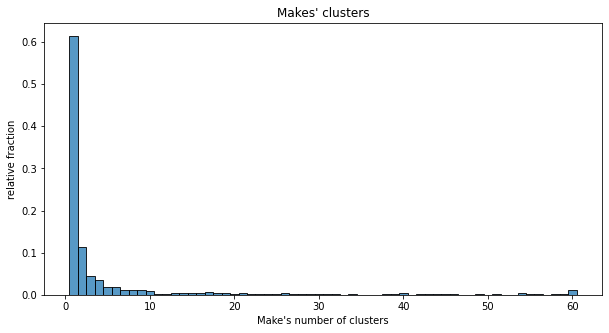

In [ ]:
fig,ax = plt.subplots(figsize=(10,5))
ax.set_title("Makes' clusters")
ax.set_xlabel("Make's number of clusters")
ax.set_ylabel("relative fraction")
ax = sns.histplot(data=cluster_counts, x="clusters", stat="probability", bins=np.arange(1,cluster_pipe.named_steps["cluster"].cluster_centers_.shape[0] + 2) - 0.5, ax=ax)

Approximately $62\%$ of vehicle makes has collisions belonging only to one cluster.
This means that those motorcycles made incidents with approximately the same characteristics, attributable to a single group.

In [ ]:
# (vehicle_make, cluster) collisions counts
collision_counts = pd.DataFrame({"collisions": MiniBatchKMeans_df.loc[:, ["vehicle_make", "cluster"]].value_counts()})
collision_counts = collision_counts.sort_values("collisions", ascending=False)
collision_counts.head()

collisions
vehicle_make    cluster            
harley-davidson 1              3384
                32             2968
honda           32             2396
harley-davidson 21             2132
yamaha          1              2101

In **Data preprocessing** section, a histogram showing the relative fraction of collisions per make is already present.
Now the following plot shows the relative fraction of collisions per cluster.

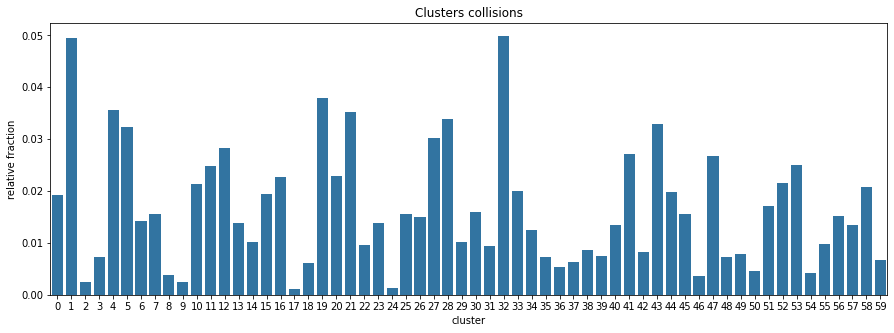

In [ ]:
collision_counts_cluster = collision_counts.groupby("cluster").collisions.sum() / collision_counts.collisions.sum()

fig,ax = plt.subplots(figsize=(15,5))
ax.set_title("Clusters collisions")
ax.set_xlabel("cluster")
ax.set_ylabel("relative fraction")
ax = sns.barplot(x=collision_counts_cluster.index, y=collision_counts_cluster.values, ax=ax, color="C0")

The results for MiniBatchKMeans are saved in CSV files and encoders and estimators are saved in PKL files.

In [ ]:
encoders_dir = "MiniBatchKMeans_encoders"
os.mkdir(encoders_dir)
for col in label_encoders.keys():
    jb.dump(label_encoders[col], encoders_dir + "/" + col + ".pkl")

estimators_dir = "MiniBatchKMeans_estimators"
os.mkdir(estimators_dir)
jb.dump(cluster_pipe, estimators_dir + "/MiniBatchKMeans_cluster_pipe.pkl")

cluster_centers.to_csv("MiniBatchKMeans_cluster_centers.csv")
cluster_counts.to_csv("MiniBatchKMeans_cluster_counts.csv")
collision_counts.to_csv("MiniBatchKMeans_collision_counts.csv")

### K-means 

In [ ]:
Kmeans_train = x.copy()
KMeans_target = y.copy()
KMeans_df= df.copy()
KMeans_df_enc = df_enc.copy()

In [ ]:
def get_Kmeans_pipe(x, n):
    cluster_pipe = pipeline.Pipeline([
        ("scaler", preprocessing.StandardScaler()),
        ("cluster", cluster.KMeans(n_clusters=n, random_state=1))
    ])
    cluster_pipe = cluster_pipe.fit(x)
    return cluster_pipe


  0%|          | 0/149 [00:00<?, ?it/s]

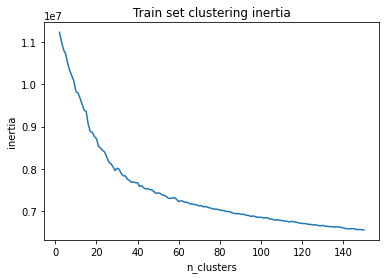

In [ ]:
# N = 150 # maximum clusters tested
# inertia = [cluster_pipe.named_steps["cluster"].inertia_ for cluster_pipe in jb.Parallel(n_jobs=-1)(jb.delayed(get_Kmeans_pipe)(Kmeans_train_svd, n) for n in trange(2,N+1))]

# ax = sns.lineplot(x=np.arange(2,N+1), y=inertia)
# ax.set_title("Train set clustering inertia")
# ax.set_xlabel("n_clusters")
# _ = ax.set_ylabel("inertia")

In [ ]:
start = time.time()
cluster_pipe = get_Kmeans_pipe(Kmeans_train, n=60)
stop = time.time()
print(f"Training time for K-means Model: {stop - start}s")
cluster_values = cluster_pipe.predict(Kmeans_train)

Training time for K-means Model: 83.52027463912964s


In [ ]:
# Kmeans_train.drop('cluster', axis=1, inplace=True)
# KMeans_df.drop('cluster', axis=1, inplace=True)
# KMeans_df_enc.drop('cluster', axis=1, inplace=True)

In [ ]:
Kmeans_train.insert(loc=Kmeans_train.shape[1], column="cluster", value=cluster_values)
KMeans_df.insert(loc=KMeans_df.shape[1], column="cluster", value=cluster_values)
KMeans_df_enc.insert(loc=KMeans_df_enc.shape[1], column="cluster", value=cluster_values)

In [ ]:
def decode_labels(df, encoders, progress=False):
    df = df.copy()
    for col in encoders.keys():
        if col in df.columns:
            df.loc[:,col] = encoders[col].inverse_transform(df.loc[:,col].apply(lambda x: round(x))) # decode with the nearest valid label
    return df

# cluster characteristics
#cluster_centers = pd.DataFrame(cluster_pipe.named_steps["scaler"].inverse_transform(cluster_pipe.named_steps["cluster"].cluster_centers_), columns=x2.drop(columns="cluster").columns)
#cluster_centers.index.name = "cluster"
cluster_centers = decode_labels(Kmeans_train.drop(columns="cluster"), label_encoders)
cluster_centers.head()

,,party_type,at_fault,party_sex,party_age,party_sobriety,party_drug_physical,direction_of_travel,party_safety_equipment_1,party_safety_equipment_2,financial_responsibility,hazardous_materials,school_bus_related,oaf_violation_code,oaf_violation_category,oaf_violation_section,oaf_violation_suffix,other_associate_factor_1,other_associate_factor_2,party_number_killed,party_number_injured,movement_preceding_collision,vehicle_year,party_race,county_city_location,special_condition,beat_type,chp_beat_type,city_division_lapd,chp_beat_class,beat_number,primary_road,secondary_road,distance,direction,intersection,weather_1,weather_2,state_highway_indicator,caltrans_county,caltrans_district,...,pcf_violation_category,pcf_violation,pcf_violation_subsection,hit_and_run,type_of_collision,motor_vehicle_involved_with,pedestrian_action,road_surface,road_condition_1,road_condition_2,lighting,control_device,chp_road_type,pedestrian_collision,bicycle_collision,motorcycle_collision,truck_collision,not_private_property,alcohol_involved,statewide_vehicle_type_at_fault,chp_vehicle_type_at_fault,severe_injury_count,other_visible_injury_count,complaint_of_pain_injury_count,pedestrian_killed_count,pedestrian_injured_count,bicyclist_killed_count,bicyclist_injured_count,motorcyclist_killed_count,motorcyclist_injured_count,primary_ramp,secondary_ramp,latitude,longitude,collision_date_year,collision_date_month,collision_date_day,collision_date_hour,collision_date_minute,collision_date_second
case_id,party_number,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1000019,1,driver,1,male,34.0,had not been drinking,None,east,"driver, motorcycle helmet used",None,proof of insurance obtained,0.0,0.0,None,None,None,None,none apparent,None,1,0,proceeding straight,1998.0,white,1900,0,chp county roadarea,county road area,None,chp primary,010,MULHOLLAND HWY,WARING DR,173.0,east,0.0,clear,None,0.0,None,0.0,...,speeding,22350.0,None,not hit and run,overturned,non-collision,no pedestrian involved,dry,normal,None,daylight,none,0,0,0,1,0,1,0.0,motorcycle or scooter,motorcycle,0,0,0,0,0,0,0,1,0,None,None,0.0,0.0,2003,9,7,15,30,0
1000056,2,driver,0,male,48.0,had not been drinking,None,north,"driver, motorcycle helmet used",None,proof of insurance obtained,0.0,0.0,None,None,None,None,none apparent,None,0,1,proceeding straight,1982.0,white,5690,0,chp county roadarea,county road area,None,chp other,007,MOORPARK RD,READ RD,0.0,None,1.0,clear,None,0.0,None,0.0,...,automobile right of way,21801.0,A,not hit and run,broadside,other motor vehicle,no pedestrian involved,dry,normal,None,daylight,functioning,0,0,0,1,0,1,0.0,pickup or panel truck,pickups & panels,0,1,0,0,0,0,0,0,1,None,None,0.0,0.0,2003,9,3,7,45,0
1000079,1,driver,1,male,31.0,had not been drinking,None,south,not required,None,proof of insurance obtained,0.0,0.0,None,None,None,None,none apparent,None,0,0,proceeding straight,2003.0,hispanic,1900,0,chp county roadline,county road line,None,chp primary,128,MULHOLLAND HWY,SIERRA CREEK RD,250.0,south,0.0,clear,None,0.0,None,0.0,...,speeding,22350.0,None,not hit and run,overturned,non-collision,no pedestrian involved,dry,normal,None,daylight,none,0,0,0,1,0,1,0.0,motorcycle or scooter,motorcycle,0,0,0,0,0,0,0,0,0,None,None,0.0,0.0,2003,8,17,18,55,0
1000202,3,driver,0,male,34.0,had not been drinking,None,north,"driver, motorcycle helmet used",None,proof of insurance obtained,0.0,0.0,None,None,None,None,none apparent,None,1,0,proceeding straight,2000.0,white,3022,0,chp state highway,state route,None,chp other,552,RT 55,S TUSTIN,450.0,north,0.0,clear,None,1.0,orange,12.0,...,other equipment,29003.0,A,felony,sideswipe,other motor vehicle,no pedestrian involved,dry,normal,None,daylight,none,6,0,0,1,1,1,0.0,truck or truck tractor with trailer,two axle truck,0,0,0,0,0,0,0,1,0,None,None,0.0,0.0,2003,8,11,8,38,0
1000260,1,driver,1,male,32.0,had not been drinking,None,south,"driver, motorcycle helmet used",None,proof of insurance obtained,0.0,0.0,None,None,Non

In [ ]:
# clusters counts per vehicle make
cluster_counts = pd.DataFrame({"clusters": KMeans_df.groupby("vehicle_make").cluster.nunique()})
cluster_counts = cluster_counts.sort_index().sort_values("clusters", ascending=False)
cluster_counts.head()

,clusters
vehicle_make,
honda,60
yamaha,58
suzuki,58
harley-davidson,57
kawasaki,57


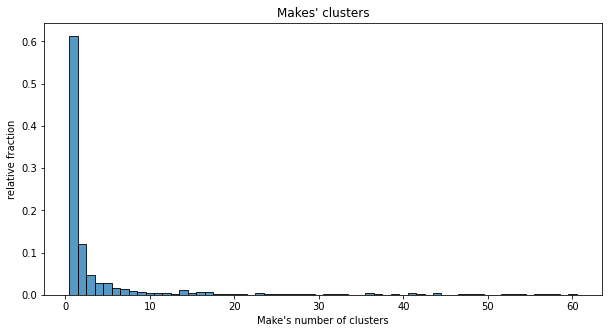

In [ ]:
fig,ax = plt.subplots(figsize=(10,5))
ax.set_title("Makes' clusters")
ax.set_xlabel("Make's number of clusters")
ax.set_ylabel("relative fraction")
ax = sns.histplot(data=cluster_counts, x="clusters", stat="probability", bins=np.arange(1,cluster_pipe.named_steps["cluster"].cluster_centers_.shape[0] + 2) - 0.5, ax=ax)

In [ ]:
# (vehicle_make, cluster) collisions counts
collision_counts = pd.DataFrame({"collisions": KMeans_df.loc[:, ["vehicle_make", "cluster"]].value_counts()})
collision_counts = collision_counts.sort_values("collisions", ascending=False)
collision_counts.head()

collisions
vehicle_make    cluster            
harley-davidson 35             3584
                57             3082
                41             2599
                39             2592
                2              2415

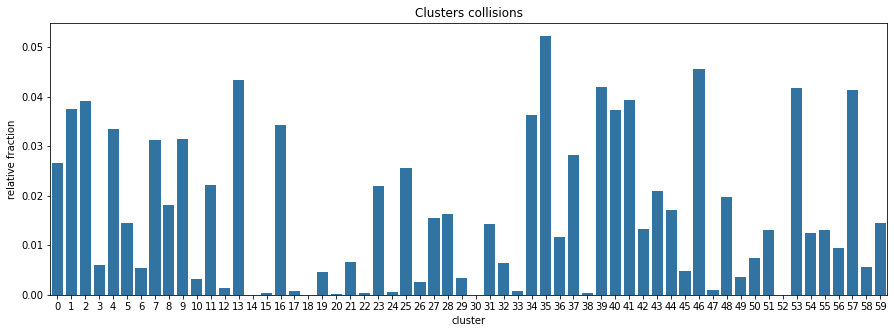

In [ ]:
collision_counts_cluster = collision_counts.groupby("cluster").collisions.sum() / collision_counts.collisions.sum()

fig,ax = plt.subplots(figsize=(15,5))
ax.set_title("Clusters collisions")
ax.set_xlabel("cluster")
ax.set_ylabel("relative fraction")
ax = sns.barplot(x=collision_counts_cluster.index, y=collision_counts_cluster.values, ax=ax, color="C0")

In [ ]:
encoders_dir = "KMeans_encoders"
os.mkdir(encoders_dir)
for col in label_encoders.keys():
    jb.dump(label_encoders[col], encoders_dir + "/" + col + ".pkl")

estimators_dir = "KMeans_estimators"
os.mkdir(estimators_dir)
jb.dump(cluster_pipe, estimators_dir + "/KMeans_cluster_pipe.pkl")

cluster_centers.to_csv("KMeans_cluster_centers.csv")
cluster_counts.to_csv("KMeans_cluster_counts.csv")
collision_counts.to_csv("KMeans_collision_counts.csv")

### BIRCH

In [ ]:
BIRCH_train = x.iloc[0:9999,:]
BIRCH_target = y.iloc[0:9999,:]
BIRCH_df= df.iloc[0:9999,:]
BIRCH_df_enc = df_enc.iloc[0:9999,:]


# BIRCH_train = x.copy()
# BIRCH_target = y.copy()
# BIRCH_df= df.copy()
# BIRCH_df_enc = df_enc.copy()

In [ ]:
svd = decomposition.TruncatedSVD(n_components=70)
svd.fit(BIRCH_train)
BIRCH_train_svd = svd.transform(BIRCH_train)

In [ ]:
def get_BIRCH_pipe(x, n, batch_size=1000):
    cluster_pipe = pipeline.Pipeline([
        ("scaler", preprocessing.StandardScaler()),
        ("cluster", cluster.Birch(threshold=0.03, n_clusters=n))
    ])
    # cluster_pipe = cluster_pipe.fit(x)
    return cluster_pipe

In [ ]:
score = []
for n in range(2,250) :
  score.append(metrics.silhouette_score(BIRCH_train_svd, get_BIRCH_pipe(BIRCH_train_svd,n).fit_predict(BIRCH_train_svd)))
  print("No. of clusters",n)

No. of clusters 2
No. of clusters 3
No. of clusters 4
No. of clusters 5
No. of clusters 6
No. of clusters 7
No. of clusters 8
No. of clusters 9
No. of clusters 10
No. of clusters 11
No. of clusters 12
No. of clusters 13
No. of clusters 14
No. of clusters 15
No. of clusters 16
No. of clusters 17
No. of clusters 18
No. of clusters 19
No. of clusters 20
No. of clusters 21
No. of clusters 22
No. of clusters 23
No. of clusters 24
No. of clusters 25
No. of clusters 26
No. of clusters 27
No. of clusters 28
No. of clusters 29
No. of clusters 30
No. of clusters 31
No. of clusters 32
No. of clusters 33
No. of clusters 34
No. of clusters 35
No. of clusters 36
No. of clusters 37
No. of clusters 38
No. of clusters 39
No. of clusters 40
No. of clusters 41
No. of clusters 42
No. of clusters 43
No. of clusters 44
No. of clusters 45
No. of clusters 46
No. of clusters 47
No. of clusters 48
No. of clusters 49
No. of clusters 50
No. of clusters 51
No. of clusters 52
No. of clusters 53
No. of clusters 54
N

In [ ]:
len(score) 

248

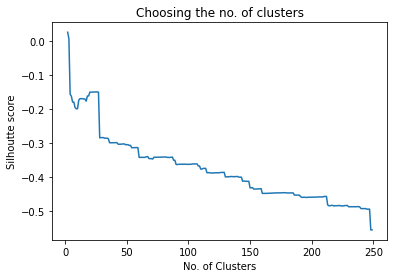

In [ ]:
ax = sns.lineplot(x=np.arange(2,250), y=score)
ax.set_title("Choosing the no. of clusters")
ax.set_xlabel("No. of Clusters")
_ = ax.set_ylabel("Silhoutte score")


(5.0, 35.0)

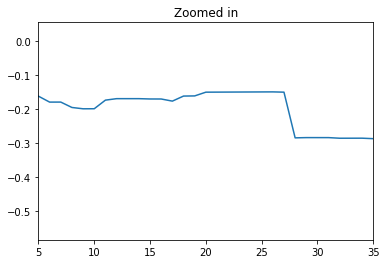

In [ ]:
ax = sns.lineplot(x=np.arange(2,250), y=score)
ax.set_title('Zoomed in')
ax.set_xlim([5,35])

In [ ]:
birch_model = cluster.Birch(threshold=0.03, n_clusters=25)
start = time.time()
birch_result = birch_model.fit_predict(BIRCH_train_svd)
stop = time.time()
print(f"Training time for BIRCH Model: {stop - start}s")

Training time for BIRCH Model: 6.547949552536011s


In [ ]:
cluster_centres = len(np.unique(birch_model.labels_))
cluster_centres  ##25

25

In [ ]:
# BIRCH_train.drop('cluster', axis=1, inplace=True)
# BIRCH_df.drop('cluster', axis=1, inplace=True)
# BIRCH_df_enc.drop('cluster', axis=1, inplace=True)

In [ ]:
BIRCH_train.insert(loc=BIRCH_train.shape[1], column="cluster", value=birch_result)
BIRCH_df.insert(loc=BIRCH_df.shape[1], column="cluster", value=birch_result)
BIRCH_df_enc.insert(loc=BIRCH_df_enc.shape[1], column="cluster", value=birch_result)

In [ ]:
def decode_labels(df, encoders, progress=False):
    df = df.copy()
    for col in encoders.keys():
        if col in df.columns:
            df.loc[:,col] = encoders[col].inverse_transform(df.loc[:,col].apply(lambda x: round(x))) # decode with the nearest valid label
    return df

# cluster characteristics
#cluster_centers = pd.DataFrame(cluster_pipe.named_steps["scaler"].inverse_transform(cluster_pipe.named_steps["cluster"].cluster_centers_), columns=x2.drop(columns="cluster").columns)
#cluster_centers.index.name = "cluster"
cluster_centers = decode_labels(BIRCH_train.drop(columns="cluster"), label_encoders)
cluster_centers.head()

,,party_type,at_fault,party_sex,party_age,party_sobriety,party_drug_physical,direction_of_travel,party_safety_equipment_1,party_safety_equipment_2,financial_responsibility,hazardous_materials,school_bus_related,oaf_violation_code,oaf_violation_category,oaf_violation_section,oaf_violation_suffix,other_associate_factor_1,other_associate_factor_2,party_number_killed,party_number_injured,movement_preceding_collision,vehicle_year,party_race,county_city_location,special_condition,beat_type,chp_beat_type,city_division_lapd,chp_beat_class,beat_number,primary_road,secondary_road,distance,direction,intersection,weather_1,weather_2,state_highway_indicator,caltrans_county,caltrans_district,...,pcf_violation_category,pcf_violation,pcf_violation_subsection,hit_and_run,type_of_collision,motor_vehicle_involved_with,pedestrian_action,road_surface,road_condition_1,road_condition_2,lighting,control_device,chp_road_type,pedestrian_collision,bicycle_collision,motorcycle_collision,truck_collision,not_private_property,alcohol_involved,statewide_vehicle_type_at_fault,chp_vehicle_type_at_fault,severe_injury_count,other_visible_injury_count,complaint_of_pain_injury_count,pedestrian_killed_count,pedestrian_injured_count,bicyclist_killed_count,bicyclist_injured_count,motorcyclist_killed_count,motorcyclist_injured_count,primary_ramp,secondary_ramp,latitude,longitude,collision_date_year,collision_date_month,collision_date_day,collision_date_hour,collision_date_minute,collision_date_second
case_id,party_number,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1000019,1,driver,1,male,34.0,had not been drinking,None,east,"driver, motorcycle helmet used",None,proof of insurance obtained,0.0,0.0,None,None,None,None,none apparent,None,1,0,proceeding straight,1998.0,white,1900,0,chp county roadarea,county road area,None,chp primary,010,MULHOLLAND HWY,WARING DR,173.0,east,0.0,clear,None,0.0,None,0.0,...,speeding,22350.0,None,not hit and run,overturned,non-collision,no pedestrian involved,dry,normal,None,daylight,none,0,0,0,1,0,1,0.0,motorcycle or scooter,motorcycle,0,0,0,0,0,0,0,1,0,None,None,0.0,0.0,2003,9,7,15,30,0
1000056,2,driver,0,male,48.0,had not been drinking,None,north,"driver, motorcycle helmet used",None,proof of insurance obtained,0.0,0.0,None,None,None,None,none apparent,None,0,1,proceeding straight,1982.0,white,5690,0,chp county roadarea,county road area,None,chp other,007,MOORPARK RD,READ RD,0.0,None,1.0,clear,None,0.0,None,0.0,...,automobile right of way,21801.0,A,not hit and run,broadside,other motor vehicle,no pedestrian involved,dry,normal,None,daylight,functioning,0,0,0,1,0,1,0.0,pickup or panel truck,pickups & panels,0,1,0,0,0,0,0,0,1,None,None,0.0,0.0,2003,9,3,7,45,0
1000079,1,driver,1,male,31.0,had not been drinking,None,south,not required,None,proof of insurance obtained,0.0,0.0,None,None,None,None,none apparent,None,0,0,proceeding straight,2003.0,hispanic,1900,0,chp county roadline,county road line,None,chp primary,128,MULHOLLAND HWY,SIERRA CREEK RD,250.0,south,0.0,clear,None,0.0,None,0.0,...,speeding,22350.0,None,not hit and run,overturned,non-collision,no pedestrian involved,dry,normal,None,daylight,none,0,0,0,1,0,1,0.0,motorcycle or scooter,motorcycle,0,0,0,0,0,0,0,0,0,None,None,0.0,0.0,2003,8,17,18,55,0
1000202,3,driver,0,male,34.0,had not been drinking,None,north,"driver, motorcycle helmet used",None,proof of insurance obtained,0.0,0.0,None,None,None,None,none apparent,None,1,0,proceeding straight,2000.0,white,3022,0,chp state highway,state route,None,chp other,552,RT 55,S TUSTIN,450.0,north,0.0,clear,None,1.0,orange,12.0,...,other equipment,29003.0,A,felony,sideswipe,other motor vehicle,no pedestrian involved,dry,normal,None,daylight,none,6,0,0,1,1,1,0.0,truck or truck tractor with trailer,two axle truck,0,0,0,0,0,0,0,1,0,None,None,0.0,0.0,2003,8,11,8,38,0
1000260,1,driver,1,male,32.0,had not been drinking,None,south,"driver, motorcycle helmet used",None,proof of insurance obtained,0.0,0.0,None,None,Non

In [ ]:
# clusters counts per vehicle make
cluster_counts = pd.DataFrame({"clusters": BIRCH_df.groupby("vehicle_make").cluster.nunique()})
cluster_counts = cluster_counts.sort_index().sort_values("clusters", ascending=False)
cluster_counts.head()

,clusters
vehicle_make,
yamaha,25
honda,25
suzuki,25
kawasaki,24
harley-davidson,24


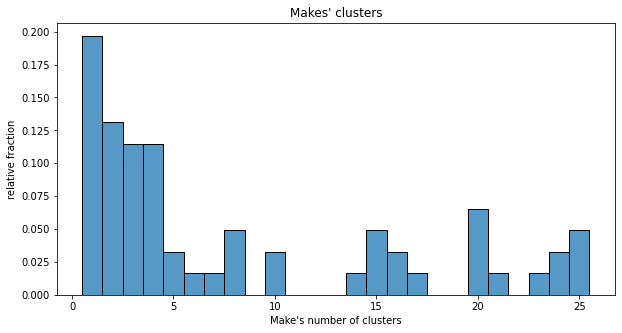

In [ ]:
fig,ax = plt.subplots(figsize=(10,5))
ax.set_title("Makes' clusters")
ax.set_xlabel("Make's number of clusters")
ax.set_ylabel("relative fraction")
ax = sns.histplot(data=cluster_counts, x="clusters", stat="probability", bins=np.arange(1,cluster_centres+2) - 0.5, ax=ax)

In [ ]:
# (vehicle_make, cluster) collisions counts
collision_counts = pd.DataFrame({"collisions": BIRCH_df.loc[:, ["vehicle_make", "cluster"]].value_counts()})
collision_counts = collision_counts.sort_values("collisions", ascending=False)
collision_counts.head()

collisions
vehicle_make    cluster            
honda           0               265
                1               238
                8               230
                3               225
harley-davidson 0               215

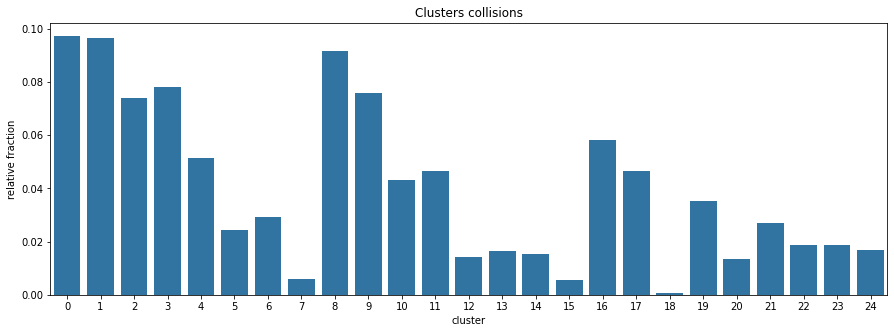

In [ ]:
collision_counts_cluster = collision_counts.groupby("cluster").collisions.sum() / collision_counts.collisions.sum()

fig,ax = plt.subplots(figsize=(15,5))
ax.set_title("Clusters collisions")
ax.set_xlabel("cluster")
ax.set_ylabel("relative fraction")
ax = sns.barplot(x=collision_counts_cluster.index, y=collision_counts_cluster.values, ax=ax, color="C0")

In [ ]:
encoders_dir = "BIRCH_encoders"
os.mkdir(encoders_dir)
for col in label_encoders.keys():
    jb.dump(label_encoders[col], encoders_dir + "/" + col + ".pkl")

estimators_dir = "BIRCH_estimators"
os.mkdir(estimators_dir)
jb.dump(birch_model, estimators_dir + "/BIRCH_cluster_pipe.pkl")

cluster_centers.to_csv("BIRCH_cluster_centers.csv")
cluster_counts.to_csv("BIRCH_cluster_counts.csv")
collision_counts.to_csv("BIRCH_collision_counts.csv")

### Agglomerative

In [ ]:
AC_train = x.iloc[0:9999,:]
AC_target = y.iloc[0:9999,:]
AC_df= df.iloc[0:9999,:]
AC_df_enc = df_enc.iloc[0:9999,:]

# AC_train = x.copy()
# AC_target = y.copy()
# AC_df= df.copy()
# AC_df_enc = df_enc.copy()

In [ ]:
svd = decomposition.TruncatedSVD(n_components=70)
svd.fit(AC_train)
AC_train_svd = svd.transform(AC_train)

In [ ]:
AC_train_svd

array([[ 6.32341313e+04,  1.31787142e+04, -2.39890037e+02, ...,
        -9.61372785e-02,  1.89085423e-01, -1.07165795e-01],
       [ 5.17446839e+04,  4.73692734e+03, -9.51832981e+02, ...,
         1.93667028e-01,  1.16778193e-02, -1.61160601e-02],
       [ 5.65463821e+04,  7.75475785e+03, -8.10527776e+02, ...,
         5.23462647e-02, -2.38763457e-02,  1.27867192e-02],
       ...,
       [ 3.47779154e+04, -9.84491766e+03, -2.49002481e+03, ...,
        -2.24791085e-02, -7.23565929e-03,  4.10025983e-02],
       [ 3.81003103e+04, -1.08727744e+04,  5.96466532e+02, ...,
        -3.05116626e-01,  1.60688987e-01,  2.51454181e-02],
       [ 2.98405023e+04, -1.84165794e+04,  1.55962165e+02, ...,
         3.22375325e-04, -8.35356578e-03,  3.56913843e-01]])

In [ ]:
def get_Agglomerative_clustering_pipe(x, n, batch_size=1000):
    cluster_pipe = pipeline.Pipeline([
        ("scaler", preprocessing.StandardScaler()),
        ("cluster", cluster.AgglomerativeClustering(n_clusters=n))
    ])
    # cluster_pipe = cluster_pipe.fit(x)
    return cluster_pipe


In [ ]:
N = 250 # maximum clusters tested
score  = [cluster_pipe.named_steps["cluster"].distances_ for cluster_pipe in jb.Parallel(n_jobs=-1)(jb.delayed(get_Agglomerative_clustering_pipe)(AC_train_svd, n) for n in trange(2,N+1))]

ax = sns.lineplot(x=np.arange(2,N+1), y=score)
ax.set_title("Choosing the no. of clusters")
ax.set_xlabel("No. of Clusters")
_ = ax.set_ylabel("Score")

In [ ]:
score = []
for n in range(2,250) :
  score.append(metrics.silhouette_score(AC_train_svd, get_Agglomerative_clustering_pipe(AC_train_svd,n).fit_predict(AC_train_svd)))

In [ ]:
len(score)

248

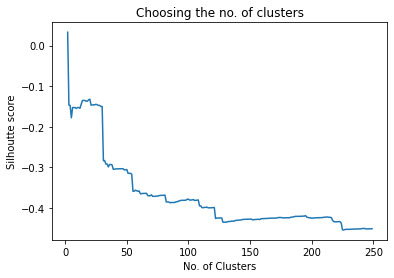

In [ ]:
ax = sns.lineplot(x=np.arange(2,250), y=score)
ax.set_title("Choosing the no. of clusters")
ax.set_xlabel("No. of Clusters")
_ = ax.set_ylabel("Silhoutte score")

In [ ]:
ac_model = get_Agglomerative_clustering_pipe(AC_train_svd, n=50)
start = time.time()
ac_result = ac_model.fit_predict(AC_train_svd)
stop = time.time()
print(f"Training time for Agglomerative Model: {stop - start}s")

Training time for Agglomerative Model: 4.856683254241943s


In [ ]:
score = metrics.silhouette_score(AC_train_svd, ac_result)
score

-0.32284337035585076

In [ ]:
AC_train.drop('cluster', axis=1, inplace=True)
AC_df.drop('cluster', axis=1, inplace=True)
AC_df_enc.drop('cluster', axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
AC_train.insert(loc=AC_train.shape[1], column="cluster", value=ac_result)
AC_df.insert(loc=AC_df.shape[1], column="cluster", value=ac_result)
AC_df_enc.insert(loc=AC_df_enc.shape[1], column="cluster", value=ac_result)

In [ ]:
def decode_labels(df, encoders, progress=False):
    df = df.copy()
    for col in encoders.keys():
        if col in df.columns:
            df.loc[:,col] = encoders[col].inverse_transform(df.loc[:,col].apply(lambda x: round(x))) # decode with the nearest valid label
    return df

# cluster characteristics
# cluster_centers = pd.DataFrame(cluster_pipe.named_steps["scaler"].inverse_transform(cluster_pipe.named_steps["cluster"].cluster_centers_), columns=x2.drop(columns="cluster").columns)
# cluster_centers.index.name = "cluster"
cluster_centers = decode_labels(AC_train.drop(columns="cluster"), label_encoders)
cluster_centers.head()

,,party_type,at_fault,party_sex,party_age,party_sobriety,party_drug_physical,direction_of_travel,party_safety_equipment_1,party_safety_equipment_2,financial_responsibility,hazardous_materials,school_bus_related,oaf_violation_code,oaf_violation_category,oaf_violation_section,oaf_violation_suffix,other_associate_factor_1,other_associate_factor_2,party_number_killed,party_number_injured,movement_preceding_collision,vehicle_year,party_race,county_city_location,special_condition,beat_type,chp_beat_type,city_division_lapd,chp_beat_class,beat_number,primary_road,secondary_road,distance,direction,intersection,weather_1,weather_2,state_highway_indicator,caltrans_county,caltrans_district,...,pcf_violation_category,pcf_violation,pcf_violation_subsection,hit_and_run,type_of_collision,motor_vehicle_involved_with,pedestrian_action,road_surface,road_condition_1,road_condition_2,lighting,control_device,chp_road_type,pedestrian_collision,bicycle_collision,motorcycle_collision,truck_collision,not_private_property,alcohol_involved,statewide_vehicle_type_at_fault,chp_vehicle_type_at_fault,severe_injury_count,other_visible_injury_count,complaint_of_pain_injury_count,pedestrian_killed_count,pedestrian_injured_count,bicyclist_killed_count,bicyclist_injured_count,motorcyclist_killed_count,motorcyclist_injured_count,primary_ramp,secondary_ramp,latitude,longitude,collision_date_year,collision_date_month,collision_date_day,collision_date_hour,collision_date_minute,collision_date_second
case_id,party_number,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1000019,1,driver,1,male,34.0,had not been drinking,None,east,"driver, motorcycle helmet used",None,proof of insurance obtained,0.0,0.0,None,None,None,None,none apparent,None,1,0,proceeding straight,1998.0,white,1900,0,chp county roadarea,county road area,None,chp primary,010,MULHOLLAND HWY,WARING DR,173.0,east,0.0,clear,None,0.0,None,0.0,...,speeding,22350.0,None,not hit and run,overturned,non-collision,no pedestrian involved,dry,normal,None,daylight,none,0,0,0,1,0,1,0.0,motorcycle or scooter,motorcycle,0,0,0,0,0,0,0,1,0,None,None,0.0,0.0,2003,9,7,15,30,0
1000056,2,driver,0,male,48.0,had not been drinking,None,north,"driver, motorcycle helmet used",None,proof of insurance obtained,0.0,0.0,None,None,None,None,none apparent,None,0,1,proceeding straight,1982.0,white,5690,0,chp county roadarea,county road area,None,chp other,007,MOORPARK RD,READ RD,0.0,None,1.0,clear,None,0.0,None,0.0,...,automobile right of way,21801.0,A,not hit and run,broadside,other motor vehicle,no pedestrian involved,dry,normal,None,daylight,functioning,0,0,0,1,0,1,0.0,pickup or panel truck,pickups & panels,0,1,0,0,0,0,0,0,1,None,None,0.0,0.0,2003,9,3,7,45,0
1000079,1,driver,1,male,31.0,had not been drinking,None,south,not required,None,proof of insurance obtained,0.0,0.0,None,None,None,None,none apparent,None,0,0,proceeding straight,2003.0,hispanic,1900,0,chp county roadline,county road line,None,chp primary,128,MULHOLLAND HWY,SIERRA CREEK RD,250.0,south,0.0,clear,None,0.0,None,0.0,...,speeding,22350.0,None,not hit and run,overturned,non-collision,no pedestrian involved,dry,normal,None,daylight,none,0,0,0,1,0,1,0.0,motorcycle or scooter,motorcycle,0,0,0,0,0,0,0,0,0,None,None,0.0,0.0,2003,8,17,18,55,0
1000202,3,driver,0,male,34.0,had not been drinking,None,north,"driver, motorcycle helmet used",None,proof of insurance obtained,0.0,0.0,None,None,None,None,none apparent,None,1,0,proceeding straight,2000.0,white,3022,0,chp state highway,state route,None,chp other,552,RT 55,S TUSTIN,450.0,north,0.0,clear,None,1.0,orange,12.0,...,other equipment,29003.0,A,felony,sideswipe,other motor vehicle,no pedestrian involved,dry,normal,None,daylight,none,6,0,0,1,1,1,0.0,truck or truck tractor with trailer,two axle truck,0,0,0,0,0,0,0,1,0,None,None,0.0,0.0,2003,8,11,8,38,0
1000260,1,driver,1,male,32.0,had not been drinking,None,south,"driver, motorcycle helmet used",None,proof of insurance obtained,0.0,0.0,None,None,Non

In [ ]:
cluster_counts = pd.DataFrame({"clusters": AC_df.groupby("vehicle_make").cluster.nunique()})
cluster_counts = cluster_counts.sort_index().sort_values("clusters", ascending=False)
cluster_counts.head()

,clusters
vehicle_make,
yamaha,50
honda,49
suzuki,49
kawasaki,49
harley-davidson,49


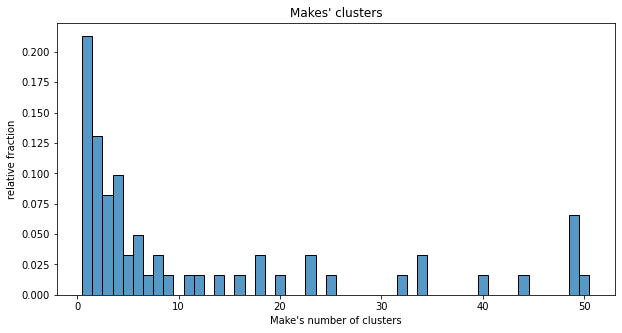

In [ ]:
fig,ax = plt.subplots(figsize=(10,5))
ax.set_title("Makes' clusters")
ax.set_xlabel("Make's number of clusters")
ax.set_ylabel("relative fraction")
ax = sns.histplot(data=cluster_counts, x="clusters", stat="probability", bins=np.arange(1,ac_model.named_steps["cluster"].n_clusters_ + 2) - 0.5, ax=ax)

In [ ]:
# (vehicle_make, cluster) collisions counts
collision_counts = pd.DataFrame({"collisions": AC_df.loc[:, ["vehicle_make", "cluster"]].value_counts()})
collision_counts = collision_counts.sort_values("collisions", ascending=False)
collision_counts.head()

,,collisions
vehicle_make,cluster,
honda,4,315
suzuki,4,210
honda,9,202
harley-davidson,4,199
honda,15,187


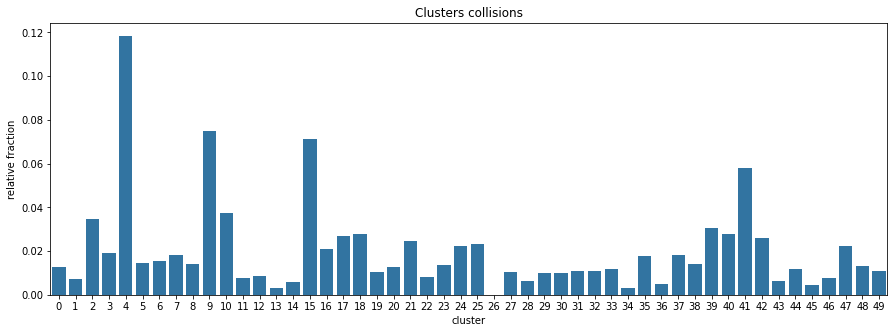

In [ ]:
collision_counts_cluster = collision_counts.groupby("cluster").collisions.sum() / collision_counts.collisions.sum()

fig,ax = plt.subplots(figsize=(15,5))
ax.set_title("Clusters collisions")
ax.set_xlabel("cluster")
ax.set_ylabel("relative fraction")
ax = sns.barplot(x=collision_counts_cluster.index, y=collision_counts_cluster.values, ax=ax, color="C0")

In [ ]:
encoders_dir = "AC_encoders"
os.mkdir(encoders_dir)
for col in label_encoders.keys():
    jb.dump(label_encoders[col], encoders_dir + "/" + col + ".pkl")

estimators_dir = "AC_estimators"
os.mkdir(estimators_dir)
jb.dump(ac_model, estimators_dir + "/AC_cluster_pipe.pkl")

cluster_centers.to_csv("AC_cluster_centers.csv")
cluster_counts.to_csv("AC_cluster_counts.csv")
collision_counts.to_csv("AC_collision_counts.csv")

### DBSCAN


In [ ]:
DBSCAN_train = x.iloc[0:9999,:]
DBSCAN_target = y.iloc[0:9999,:]
DBSCAN_df= df.iloc[0:9999:]
DBSCAN_df_enc = df_enc.iloc[0:9999,:]

In [ ]:
svd = decomposition.TruncatedSVD(n_components=70)
svd.fit(DBSCAN_train)
DBSCAN_train_svd = svd.transform(DBSCAN_train)

In [ ]:
def get_DBSCAN_pipe(x, eps) :
    cluster_pipe = pipeline.Pipeline([
        ("scaler", preprocessing.StandardScaler()),
        ("cluster", cluster.DBSCAN(eps=eps, min_samples=9))
    ])
    return cluster_pipe

In [ ]:
score = []

In [ ]:

for eps in np.arange(2,25,1) :
  pred = get_DBSCAN_pipe(DBSCAN_train_svd,eps).fit_predict(DBSCAN_train_svd)
  print("epsilon",eps)
  if(len(np.unique(pred))>1) :
     score1 = metrics.silhouette_score(DBSCAN_train_svd,pred)
     print(eps,score1)
     score.append(score1)

epsilon 2
epsilon 3
epsilon 4
4 -0.2696015746364707
epsilon 5
5 -0.18618784746670605
epsilon 6
6 -0.33385965051070304
epsilon 7
7 -0.23391734002114592
epsilon 8
8 -0.2204717853416954
epsilon 9
9 -0.10714131480377989
epsilon 10
10 -0.1759055617655453
epsilon 11
11 0.059116523539783604
epsilon 12
12 -0.04050456780910692
epsilon 13
13 0.037451474037118265
epsilon 14
14 -0.053304801034633316
epsilon 15
15 -0.15189131276011167
epsilon 16
16 -0.1412733493652908
epsilon 17
17 -0.1770534273820482
epsilon 18
18 -0.1770534273820482
epsilon 19
19 -0.1770534273820482
epsilon 20
20 -0.1770534273820482
epsilon 21
21 -0.1770534273820482
epsilon 22
22 -0.1770534273820482
epsilon 23
23 -0.1770534273820482
epsilon 24
24 -0.1770534273820482


In [ ]:
print(len(score))
print(len(np.arange(3,24,1)))

21
21


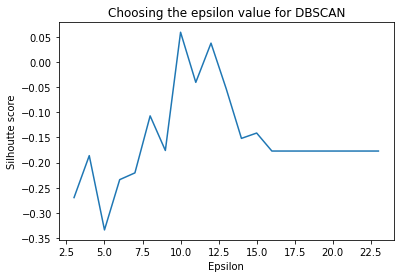

In [ ]:
ax = sns.lineplot(x=np.arange(3,24,1), y=score)
ax.set_title("Choosing the epsilon value for DBSCAN")
ax.set_xlabel("Epsilon")
_ = ax.set_ylabel("Silhoutte score")

(9.5, 10.5)

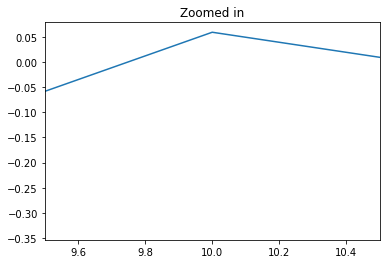

In [ ]:
ax = sns.lineplot(x=np.arange(3,24,1), y=score)
ax.set_title('Zoomed in')
ax.set_xlim([9.5,10.5])

In [ ]:
dbscan_model = get_DBSCAN_pipe(DBSCAN_train_svd,eps=10).named_steps["cluster"]
dbscan_result = dbscan_model.fit_predict(DBSCAN_train_svd)

In [ ]:
clusters=np.unique(dbscan_result)
clusters

array([-1])

In [ ]:
# DBSCAN_train.drop('cluster', axis=1, inplace=True)
# DBSCAN_df.drop('cluster', axis=1, inplace=True)
# DBSCAN_df_enc.drop('cluster', axis=1, inplace=True)

In [ ]:
DBSCAN_train.insert(loc=DBSCAN_train.shape[1], column="cluster", value=dbscan_result)
DBSCAN_df.insert(loc=DBSCAN_df.shape[1], column="cluster", value=dbscan_result)
DBSCAN_df_enc.insert(loc=DBSCAN_df_enc.shape[1], column="cluster", value=dbscan_result)

In [ ]:
def decode_labels(df, encoders, progress=False):
    df = df.copy()
    for col in encoders.keys():
        if col in df.columns:
            df.loc[:,col] = encoders[col].inverse_transform(df.loc[:,col].apply(lambda x: round(x))) # decode with the nearest valid label
    return df

# cluster characteristics
#cluster_centers = pd.DataFrame(cluster_pipe.named_steps["scaler"].inverse_transform(cluster_pipe.named_steps["cluster"].cluster_centers_), columns=x2.drop(columns="cluster").columns)
#cluster_centers.index.name = "cluster"
cluster_centers = decode_labels(DBSCAN_train.drop(columns="cluster"), label_encoders)
cluster_centers.head()

,,party_type,at_fault,party_sex,party_age,party_sobriety,party_drug_physical,direction_of_travel,party_safety_equipment_1,party_safety_equipment_2,financial_responsibility,hazardous_materials,school_bus_related,oaf_violation_code,oaf_violation_category,oaf_violation_section,oaf_violation_suffix,other_associate_factor_1,other_associate_factor_2,party_number_killed,party_number_injured,movement_preceding_collision,vehicle_year,party_race,county_city_location,special_condition,beat_type,chp_beat_type,city_division_lapd,chp_beat_class,beat_number,primary_road,secondary_road,distance,direction,intersection,weather_1,weather_2,state_highway_indicator,caltrans_county,caltrans_district,...,pcf_violation_category,pcf_violation,pcf_violation_subsection,hit_and_run,type_of_collision,motor_vehicle_involved_with,pedestrian_action,road_surface,road_condition_1,road_condition_2,lighting,control_device,chp_road_type,pedestrian_collision,bicycle_collision,motorcycle_collision,truck_collision,not_private_property,alcohol_involved,statewide_vehicle_type_at_fault,chp_vehicle_type_at_fault,severe_injury_count,other_visible_injury_count,complaint_of_pain_injury_count,pedestrian_killed_count,pedestrian_injured_count,bicyclist_killed_count,bicyclist_injured_count,motorcyclist_killed_count,motorcyclist_injured_count,primary_ramp,secondary_ramp,latitude,longitude,collision_date_year,collision_date_month,collision_date_day,collision_date_hour,collision_date_minute,collision_date_second
case_id,party_number,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1000019,1,driver,1,male,34.0,had not been drinking,None,east,"driver, motorcycle helmet used",None,proof of insurance obtained,0.0,0.0,None,None,None,None,none apparent,None,1,0,proceeding straight,1998.0,white,1900,0,chp county roadarea,county road area,None,chp primary,010,MULHOLLAND HWY,WARING DR,173.0,east,0.0,clear,None,0.0,None,0.0,...,speeding,22350.0,None,not hit and run,overturned,non-collision,no pedestrian involved,dry,normal,None,daylight,none,0,0,0,1,0,1,0.0,motorcycle or scooter,motorcycle,0,0,0,0,0,0,0,1,0,None,None,0.0,0.0,2003,9,7,15,30,0
1000056,2,driver,0,male,48.0,had not been drinking,None,north,"driver, motorcycle helmet used",None,proof of insurance obtained,0.0,0.0,None,None,None,None,none apparent,None,0,1,proceeding straight,1982.0,white,5690,0,chp county roadarea,county road area,None,chp other,007,MOORPARK RD,READ RD,0.0,None,1.0,clear,None,0.0,None,0.0,...,automobile right of way,21801.0,A,not hit and run,broadside,other motor vehicle,no pedestrian involved,dry,normal,None,daylight,functioning,0,0,0,1,0,1,0.0,pickup or panel truck,pickups & panels,0,1,0,0,0,0,0,0,1,None,None,0.0,0.0,2003,9,3,7,45,0
1000079,1,driver,1,male,31.0,had not been drinking,None,south,not required,None,proof of insurance obtained,0.0,0.0,None,None,None,None,none apparent,None,0,0,proceeding straight,2003.0,hispanic,1900,0,chp county roadline,county road line,None,chp primary,128,MULHOLLAND HWY,SIERRA CREEK RD,250.0,south,0.0,clear,None,0.0,None,0.0,...,speeding,22350.0,None,not hit and run,overturned,non-collision,no pedestrian involved,dry,normal,None,daylight,none,0,0,0,1,0,1,0.0,motorcycle or scooter,motorcycle,0,0,0,0,0,0,0,0,0,None,None,0.0,0.0,2003,8,17,18,55,0
1000202,3,driver,0,male,34.0,had not been drinking,None,north,"driver, motorcycle helmet used",None,proof of insurance obtained,0.0,0.0,None,None,None,None,none apparent,None,1,0,proceeding straight,2000.0,white,3022,0,chp state highway,state route,None,chp other,552,RT 55,S TUSTIN,450.0,north,0.0,clear,None,1.0,orange,12.0,...,other equipment,29003.0,A,felony,sideswipe,other motor vehicle,no pedestrian involved,dry,normal,None,daylight,none,6,0,0,1,1,1,0.0,truck or truck tractor with trailer,two axle truck,0,0,0,0,0,0,0,1,0,None,None,0.0,0.0,2003,8,11,8,38,0
1000260,1,driver,1,male,32.0,had not been drinking,None,south,"driver, motorcycle helmet used",None,proof of insurance obtained,0.0,0.0,None,None,Non

In [ ]:
# clusters counts per vehicle make
cluster_counts = pd.DataFrame({"clusters": DBSCAN_df.groupby("vehicle_make").cluster.nunique()})
cluster_counts = cluster_counts.sort_index().sort_values("clusters", ascending=False)
cluster_counts.head()

,clusters
vehicle_make,
ARGOSY,1
honda,1
hyundai,1
infiniti,1
isuzu,1


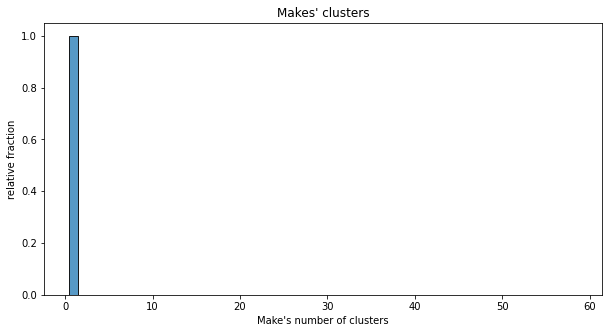

In [ ]:
fig,ax = plt.subplots(figsize=(10,5))
ax.set_title("Makes' clusters")
ax.set_xlabel("Make's number of clusters")
ax.set_ylabel("relative fraction")
ax = sns.histplot(data=cluster_counts, x="clusters", stat="probability", bins=np.arange(1,60) - 0.5, ax=ax)

In [ ]:
# (vehicle_make, cluster) collisions counts
collision_counts = pd.DataFrame({"collisions": DBSCAN_df.loc[:, ["vehicle_make", "cluster"]].value_counts()})
collision_counts = collision_counts.sort_values("collisions", ascending=False)
collision_counts.head()

,,collisions
vehicle_make,cluster,
honda,-1,2586
harley-davidson,-1,2080
suzuki,-1,1680
yamaha,-1,1438
kawasaki,-1,1053


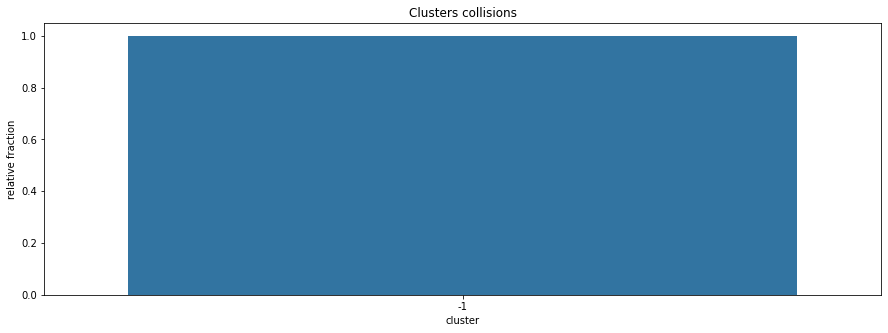

In [ ]:
collision_counts_cluster = collision_counts.groupby("cluster").collisions.sum() / collision_counts.collisions.sum()

fig,ax = plt.subplots(figsize=(15,5))
ax.set_title("Clusters collisions")
ax.set_xlabel("cluster")
ax.set_ylabel("relative fraction")
ax = sns.barplot(x=collision_counts_cluster.index, y=collision_counts_cluster.values, ax=ax, color="C0")


In [ ]:
encoders_dir = "DBSCAN_encoders"
os.mkdir(encoders_dir)
for col in label_encoders.keys():
    jb.dump(label_encoders[col], encoders_dir + "/" + col + ".pkl")

estimators_dir = "DBSCAN_estimators"
os.mkdir(estimators_dir)
jb.dump(dbscan_model, estimators_dir + "/DBSCAN_cluster_pipe.pkl")

cluster_centers.to_csv("DBSCAN_cluster_centers.csv")
cluster_counts.to_csv("DBSCAN_cluster_counts.csv")
collision_counts.to_csv("DBSCAN_collision_counts.csv")

# Parameter Estimation for Algorithms

Parameter estimation is vital to obtain accuracte and reliable clustering as well as be able to interpret

# Comparison of Clustering Algorithms (Internal Evaluation Metrics)

The clustering algorithms above were all used to derive two statistical inferences defined under project proposal : 

*   Calculate number of clusters each manufacturer appears in. (`cluster_counts`)

* Calculate relative fraction of collisions per cluster.(`collision_counts`)

Motorcycle manufacturers having most of its incidents in one cluster correlates with
the fact that these incidents have approximately the same characteristics,
attributable to a single group.

The relative fraction shows us purity of each cluster and increases confidence in prediction of vehicle manufacturer in test data.

These two metrics are referred to as `cluster_counts` and `collision_counts` and histogram dist-plots are plotted using various clustering algorithms.



# Conclusion


Work presented in this report shows how clustering could help determine common properties in one motorcycle make incidents.
The problem is that not all motorcycles can be assigned to a single type of collision: in fact many of the seen entries (about $40\%$) show for the same make different groups.
Althought the non-unique correspondence, $60\%$ of collisions presents one cluster per make.



# Future Scope


Eventually, further improvements to this notebook could be training a supervised model capable of predicting motorcycle type based on collision characteristics; in this way relation between incidents properties and motorcycle make will be further proved.